In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# Set style for better-looking plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## Ellipses and Sample Size

In [4]:
def generate_data(n, p, beta_true, sigma):
    """Generate synthetic regression data"""
    X = np.random.randn(n, p)
    epsilon = np.random.randn(n) * sigma
    y = X @ beta_true + epsilon
    return X, y

def compute_ols_estimate(X, y):
    """Compute OLS estimate"""
    return np.linalg.solve(X.T @ X, X.T @ y)

def compute_rashomon_volume(X, epsilon, p):
    """
    Compute the volume of the Rashomon ellipsoid
    Volume proportional to sqrt(epsilon)^p / sqrt(det(X^T X))
    """
    XTX = X.T @ X
    eigenvalues = np.linalg.eigvals(XTX)
    # Volume proportional to product of axis lengths
    volume = (epsilon ** (p/2)) / np.sqrt(np.prod(eigenvalues))
    return volume

def compute_ellipsoid_axes(X, epsilon):
    """Compute the principal axes lengths of the Rashomon ellipsoid"""
    XTX = X.T @ X
    eigenvalues = np.linalg.eigvals(XTX)
    axes_lengths = np.sqrt(epsilon / eigenvalues)
    return axes_lengths

def plot_2d_ellipsoid(beta_hat, XTX, epsilon, ax, label=''):
    """Plot 2D ellipsoid for visualization when p=2"""
    # Generate points on unit circle
    theta = np.linspace(0, 2*np.pi, 100)
    unit_circle = np.array([np.cos(theta), np.sin(theta)])
    
    # Transform to ellipsoid using eigendecomposition
    eigvals, eigvecs = np.linalg.eigh(XTX)
    # Scale by sqrt(epsilon/eigenvalue) for each axis
    scaling = np.diag(np.sqrt(epsilon / eigvals))
    ellipse_points = eigvecs @ scaling @ unit_circle
    
    # Translate to center at beta_hat
    ellipse_points[0, :] += beta_hat[0]
    ellipse_points[1, :] += beta_hat[1]
    
    ax.plot(ellipse_points[0, :], ellipse_points[1, :], label=label, linewidth=2)



In [5]:

# Simulation parameters
p = 2  # Number of features (kept small for visualization)
beta_true = np.ones(p)  # True parameter vector
sigma = 1.0  # Noise level
epsilon_fixed = 5.0  # Fixed absolute threshold

# Sample sizes to test
sample_sizes = np.logspace(1.5, 3.5, 20).astype(int)  # From ~30 to ~3000
n_simulations = 10  # Number of simulations per sample size

# Storage for results
volumes_fixed = []
volumes_relative = []
axes_lengths_all = []

# Run simulations
print("Running simulations...")
for n in tqdm(sample_sizes, desc="Sample sizes"):
    vols_fixed_temp = []
    vols_relative_temp = []
    axes_temp = []
    
    for _ in range(n_simulations):
        # Generate data
        X, y = generate_data(n, p, beta_true, sigma)
        
        # Compute OLS estimate
        beta_hat = compute_ols_estimate(X, y)
        
        # Compute SSE_min for relative threshold
        y_pred = X @ beta_hat
        SSE_min = np.sum((y - y_pred)**2)
        epsilon_relative = 0.1 * SSE_min  # 10% relative threshold
        
        # Compute volumes
        vol_fixed = compute_rashomon_volume(X, epsilon_fixed, p)
        vol_relative = compute_rashomon_volume(X, epsilon_relative, p)
        
        # Compute axes lengths for fixed epsilon
        axes = compute_ellipsoid_axes(X, epsilon_fixed)
        
        vols_fixed_temp.append(vol_fixed)
        vols_relative_temp.append(vol_relative)
        axes_temp.append(axes)
    
    volumes_fixed.append(vols_fixed_temp)
    volumes_relative.append(vols_relative_temp)
    axes_lengths_all.append(axes_temp)

# Convert to arrays for easier manipulation
volumes_fixed = np.array(volumes_fixed)
volumes_relative = np.array(volumes_relative)



Running simulations...


Sample sizes: 100%|████████████████████████████| 20/20 [00:00<00:00, 726.48it/s]


## Plotting


Analyzing effect of noise level...


Noise levels: 100%|███████████████████████████| 10/10 [00:00<00:00, 2063.11it/s]


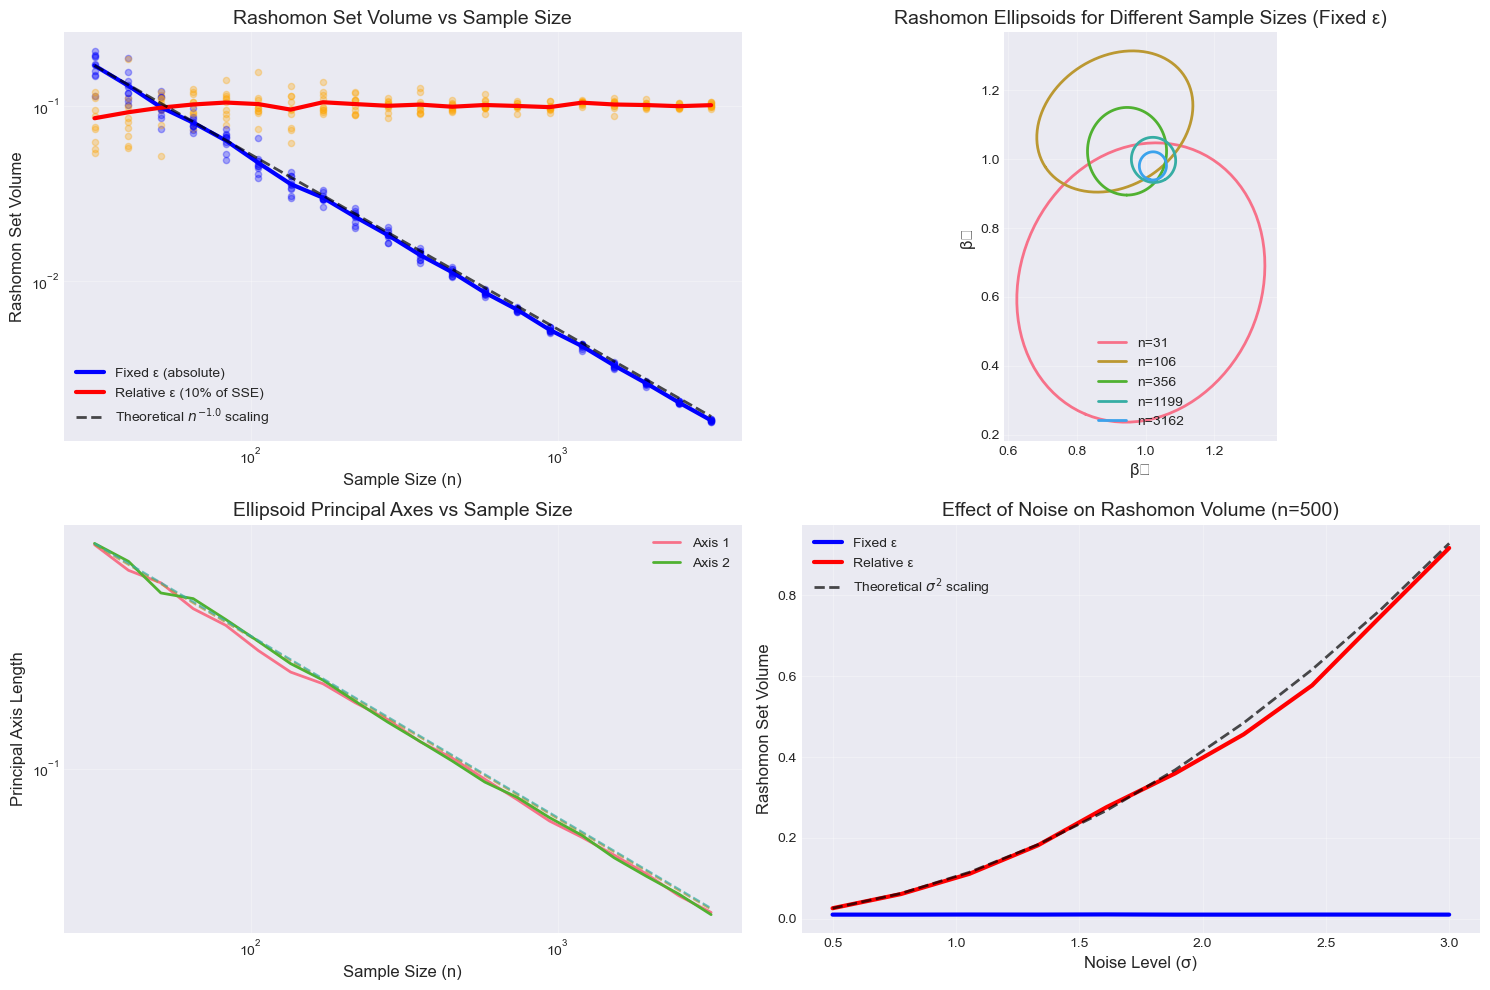

In [6]:
# Create figure with subplots
fig = plt.figure(figsize=(15, 10))

# Plot 1: Volume vs Sample Size (log-log plot)
ax1 = plt.subplot(2, 2, 1)
# Plot individual simulations as scatter
for i in range(n_simulations):
    ax1.scatter(sample_sizes, volumes_fixed[:, i], alpha=0.3, s=20, color='blue')
    ax1.scatter(sample_sizes, volumes_relative[:, i], alpha=0.3, s=20, color='orange')

# Plot means
mean_vols_fixed = np.mean(volumes_fixed, axis=1)
mean_vols_relative = np.mean(volumes_relative, axis=1)
ax1.plot(sample_sizes, mean_vols_fixed, 'b-', linewidth=3, label='Fixed ε (absolute)')
ax1.plot(sample_sizes, mean_vols_relative, 'r-', linewidth=3, label='Relative ε (10% of SSE)')

# Add theoretical scaling line for fixed epsilon
theoretical_scaling = mean_vols_fixed[0] * (sample_sizes[0] / sample_sizes) ** (p/2)
ax1.plot(sample_sizes, theoretical_scaling, 'k--', linewidth=2, 
         label=f'Theoretical $n^{{-{p/2}}}$ scaling', alpha=0.7)

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('Sample Size (n)', fontsize=12)
ax1.set_ylabel('Rashomon Set Volume', fontsize=12)
ax1.set_title('Rashomon Set Volume vs Sample Size', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Ellipsoid visualization for different sample sizes
ax2 = plt.subplot(2, 2, 2)
# Select a few sample sizes to visualize
viz_indices = [0, 5, 10, 15, 19]
colors = plt.cm.viridis(np.linspace(0, 1, len(viz_indices)))

# Generate one dataset for each selected sample size and plot ellipsoid
for idx, color in zip(viz_indices, colors):
    n = sample_sizes[idx]
    X, y = generate_data(n, p, beta_true, sigma)
    beta_hat = compute_ols_estimate(X, y)
    XTX = X.T @ X
    plot_2d_ellipsoid(beta_hat, XTX, epsilon_fixed, ax2, label=f'n={n}')

ax2.set_xlabel('β₁', fontsize=12)
ax2.set_ylabel('β₂', fontsize=12)
ax2.set_title('Rashomon Ellipsoids for Different Sample Sizes (Fixed ε)', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_aspect('equal')

# Plot 3: Principal axes lengths vs sample size
ax3 = plt.subplot(2, 2, 3)
mean_axes = np.mean(axes_lengths_all, axis=1)
for i in range(p):
    ax3.plot(sample_sizes, mean_axes[:, i], linewidth=2, label=f'Axis {i+1}')
    # Add theoretical scaling
    theoretical_axes = mean_axes[0, i] * np.sqrt(sample_sizes[0] / sample_sizes)
    ax3.plot(sample_sizes, theoretical_axes, '--', alpha=0.7)

ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlabel('Sample Size (n)', fontsize=12)
ax3.set_ylabel('Principal Axis Length', fontsize=12)
ax3.set_title('Ellipsoid Principal Axes vs Sample Size', fontsize=14)
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Effect of noise level (sigma) on Rashomon volume
ax4 = plt.subplot(2, 2, 4)
n_fixed = 500
sigmas = np.linspace(0.5, 3, 10)
vols_by_sigma_fixed = []
vols_by_sigma_relative = []

print("\nAnalyzing effect of noise level...")
for sig in tqdm(sigmas, desc="Noise levels"):
    vols_temp_fixed = []
    vols_temp_relative = []
    for _ in range(5):  # Fewer simulations for this plot
        X, y = generate_data(n_fixed, p, beta_true, sig)
        beta_hat = compute_ols_estimate(X, y)
        y_pred = X @ beta_hat
        SSE_min = np.sum((y - y_pred)**2)
        
        vol_fixed = compute_rashomon_volume(X, epsilon_fixed, p)
        vol_relative = compute_rashomon_volume(X, 0.1 * SSE_min, p)
        
        vols_temp_fixed.append(vol_fixed)
        vols_temp_relative.append(vol_relative)
    
    vols_by_sigma_fixed.append(np.mean(vols_temp_fixed))
    vols_by_sigma_relative.append(np.mean(vols_temp_relative))

ax4.plot(sigmas, vols_by_sigma_fixed, 'b-', linewidth=3, label='Fixed ε')
ax4.plot(sigmas, vols_by_sigma_relative, 'r-', linewidth=3, label='Relative ε')

# Add theoretical scaling for relative threshold
theoretical_sigma_scaling = vols_by_sigma_relative[0] * (sigmas / sigmas[0]) ** p
ax4.plot(sigmas, theoretical_sigma_scaling, 'k--', linewidth=2, 
         label=f'Theoretical $σ^{p}$ scaling', alpha=0.7)

ax4.set_xlabel('Noise Level (σ)', fontsize=12)
ax4.set_ylabel('Rashomon Set Volume', fontsize=12)
ax4.set_title(f'Effect of Noise on Rashomon Volume (n={n_fixed})', fontsize=14)
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
full

Running simulations...


Sample sizes: 100%|████████████████████████████| 20/20 [00:00<00:00, 628.29it/s]



Analyzing effect of noise level...


Noise levels: 100%|███████████████████████████| 10/10 [00:00<00:00, 1921.26it/s]


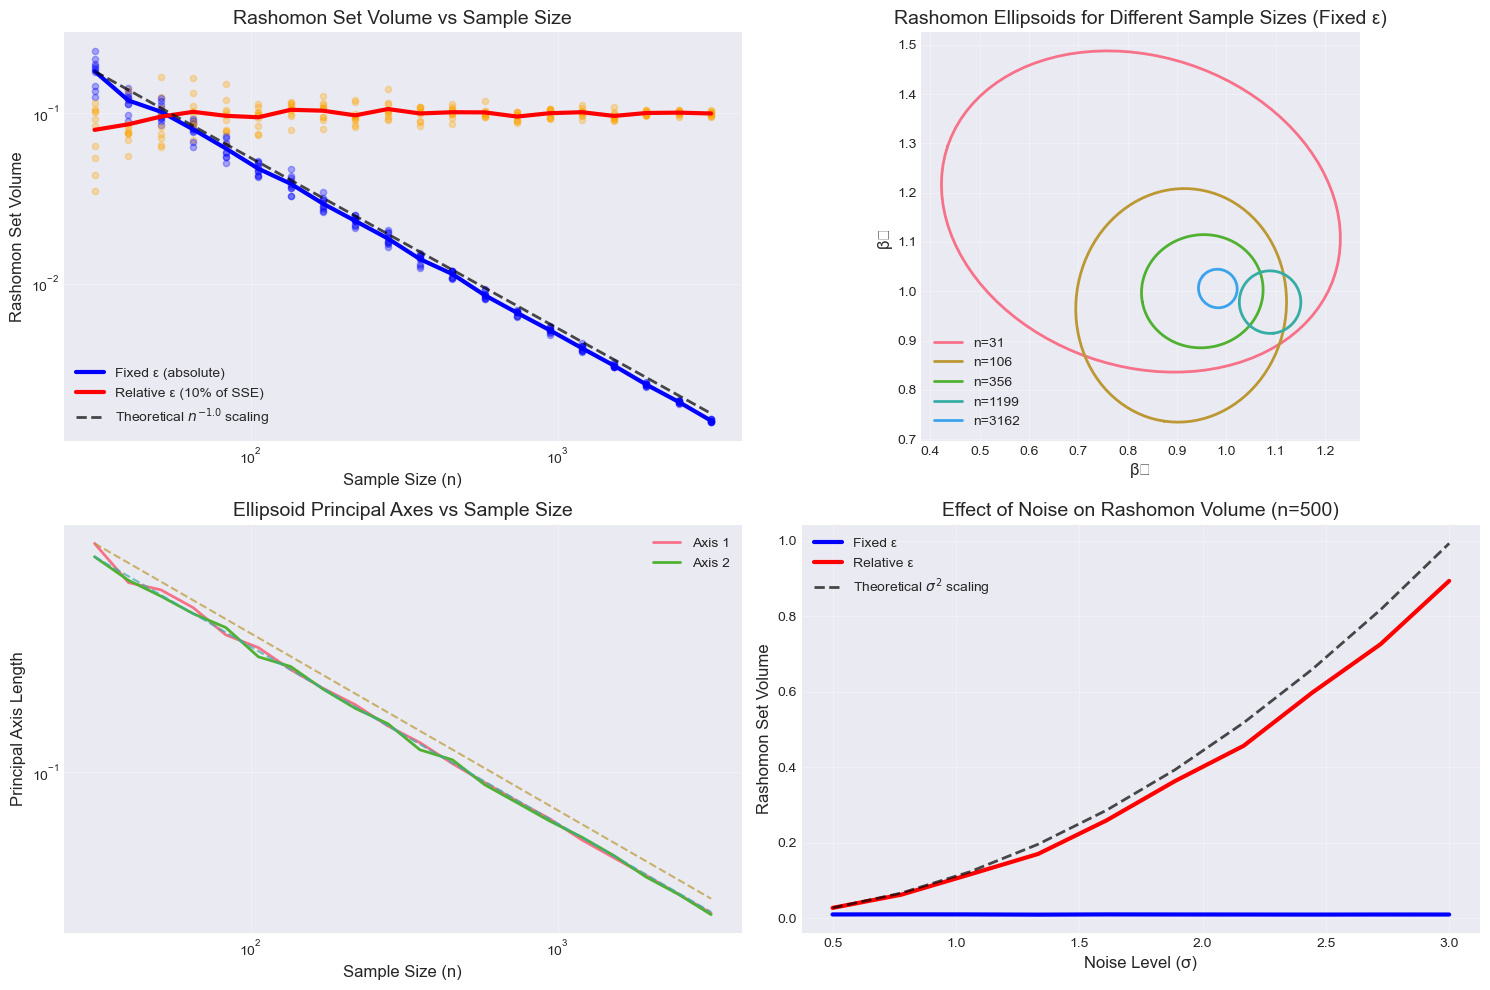

In [7]:
def generate_data(n, p, beta_true, sigma):
    """Generate synthetic regression data"""
    X = np.random.randn(n, p)
    epsilon = np.random.randn(n) * sigma
    y = X @ beta_true + epsilon
    return X, y

def compute_ols_estimate(X, y):
    """Compute OLS estimate"""
    return np.linalg.solve(X.T @ X, X.T @ y)

def compute_rashomon_volume(X, epsilon, p):
    """
    Compute the volume of the Rashomon ellipsoid
    Volume proportional to sqrt(epsilon)^p / sqrt(det(X^T X))
    """
    XTX = X.T @ X
    eigenvalues = np.linalg.eigvals(XTX)
    # Volume proportional to product of axis lengths
    volume = (epsilon ** (p/2)) / np.sqrt(np.prod(eigenvalues))
    return volume

def compute_ellipsoid_axes(X, epsilon):
    """Compute the principal axes lengths of the Rashomon ellipsoid"""
    XTX = X.T @ X
    eigenvalues = np.linalg.eigvals(XTX)
    axes_lengths = np.sqrt(epsilon / eigenvalues)
    return axes_lengths

def plot_2d_ellipsoid(beta_hat, XTX, epsilon, ax, label=''):
    """Plot 2D ellipsoid for visualization when p=2"""
    # Generate points on unit circle
    theta = np.linspace(0, 2*np.pi, 100)
    unit_circle = np.array([np.cos(theta), np.sin(theta)])
    
    # Transform to ellipsoid using eigendecomposition
    eigvals, eigvecs = np.linalg.eigh(XTX)
    # Scale by sqrt(epsilon/eigenvalue) for each axis
    scaling = np.diag(np.sqrt(epsilon / eigvals))
    ellipse_points = eigvecs @ scaling @ unit_circle
    
    # Translate to center at beta_hat
    ellipse_points[0, :] += beta_hat[0]
    ellipse_points[1, :] += beta_hat[1]
    
    ax.plot(ellipse_points[0, :], ellipse_points[1, :], label=label, linewidth=2)


# Simulation parameters
p = 2  # Number of features (kept small for visualization)
beta_true = np.ones(p)  # True parameter vector
sigma = 1.0  # Noise level
epsilon_fixed = 5.0  # Fixed absolute threshold

# Sample sizes to test
sample_sizes = np.logspace(1.5, 3.5, 20).astype(int)  # From ~30 to ~3000
n_simulations = 10  # Number of simulations per sample size

# Storage for results
volumes_fixed = []
volumes_relative = []
axes_lengths_all = []

# Run simulations
print("Running simulations...")
for n in tqdm(sample_sizes, desc="Sample sizes"):
    vols_fixed_temp = []
    vols_relative_temp = []
    axes_temp = []
    
    for _ in range(n_simulations):
        # Generate data
        X, y = generate_data(n, p, beta_true, sigma)
        
        # Compute OLS estimate
        beta_hat = compute_ols_estimate(X, y)
        
        # Compute SSE_min for relative threshold
        y_pred = X @ beta_hat
        SSE_min = np.sum((y - y_pred)**2)
        epsilon_relative = 0.1 * SSE_min  # 10% relative threshold
        
        # Compute volumes
        vol_fixed = compute_rashomon_volume(X, epsilon_fixed, p)
        vol_relative = compute_rashomon_volume(X, epsilon_relative, p)
        
        # Compute axes lengths for fixed epsilon
        axes = compute_ellipsoid_axes(X, epsilon_fixed)
        
        vols_fixed_temp.append(vol_fixed)
        vols_relative_temp.append(vol_relative)
        axes_temp.append(axes)
    
    volumes_fixed.append(vols_fixed_temp)
    volumes_relative.append(vols_relative_temp)
    axes_lengths_all.append(axes_temp)

# Convert to arrays for easier manipulation
volumes_fixed = np.array(volumes_fixed)
volumes_relative = np.array(volumes_relative)

# Create figure with subplots
fig = plt.figure(figsize=(15, 10))

# Plot 1: Volume vs Sample Size (log-log plot)
ax1 = plt.subplot(2, 2, 1)
# Plot individual simulations as scatter
for i in range(n_simulations):
    ax1.scatter(sample_sizes, volumes_fixed[:, i], alpha=0.3, s=20, color='blue')
    ax1.scatter(sample_sizes, volumes_relative[:, i], alpha=0.3, s=20, color='orange')

# Plot means
mean_vols_fixed = np.mean(volumes_fixed, axis=1)
mean_vols_relative = np.mean(volumes_relative, axis=1)
ax1.plot(sample_sizes, mean_vols_fixed, 'b-', linewidth=3, label='Fixed ε (absolute)')
ax1.plot(sample_sizes, mean_vols_relative, 'r-', linewidth=3, label='Relative ε (10% of SSE)')

# Add theoretical scaling line for fixed epsilon
theoretical_scaling = mean_vols_fixed[0] * (sample_sizes[0] / sample_sizes) ** (p/2)
ax1.plot(sample_sizes, theoretical_scaling, 'k--', linewidth=2, 
         label=f'Theoretical $n^{{-{p/2}}}$ scaling', alpha=0.7)

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('Sample Size (n)', fontsize=12)
ax1.set_ylabel('Rashomon Set Volume', fontsize=12)
ax1.set_title('Rashomon Set Volume vs Sample Size', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Ellipsoid visualization for different sample sizes
ax2 = plt.subplot(2, 2, 2)
# Select a few sample sizes to visualize
viz_indices = [0, 5, 10, 15, 19]
colors = plt.cm.viridis(np.linspace(0, 1, len(viz_indices)))

# Generate one dataset for each selected sample size and plot ellipsoid
for idx, color in zip(viz_indices, colors):
    n = sample_sizes[idx]
    X, y = generate_data(n, p, beta_true, sigma)
    beta_hat = compute_ols_estimate(X, y)
    XTX = X.T @ X
    plot_2d_ellipsoid(beta_hat, XTX, epsilon_fixed, ax2, label=f'n={n}')

ax2.set_xlabel('β₁', fontsize=12)
ax2.set_ylabel('β₂', fontsize=12)
ax2.set_title('Rashomon Ellipsoids for Different Sample Sizes (Fixed ε)', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_aspect('equal')

# Plot 3: Principal axes lengths vs sample size
ax3 = plt.subplot(2, 2, 3)
mean_axes = np.mean(axes_lengths_all, axis=1)
for i in range(p):
    ax3.plot(sample_sizes, mean_axes[:, i], linewidth=2, label=f'Axis {i+1}')
    # Add theoretical scaling
    theoretical_axes = mean_axes[0, i] * np.sqrt(sample_sizes[0] / sample_sizes)
    ax3.plot(sample_sizes, theoretical_axes, '--', alpha=0.7)

ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlabel('Sample Size (n)', fontsize=12)
ax3.set_ylabel('Principal Axis Length', fontsize=12)
ax3.set_title('Ellipsoid Principal Axes vs Sample Size', fontsize=14)
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Effect of noise level (sigma) on Rashomon volume
ax4 = plt.subplot(2, 2, 4)
n_fixed = 500
sigmas = np.linspace(0.5, 3, 10)
vols_by_sigma_fixed = []
vols_by_sigma_relative = []

print("\nAnalyzing effect of noise level...")
for sig in tqdm(sigmas, desc="Noise levels"):
    vols_temp_fixed = []
    vols_temp_relative = []
    for _ in range(5):  # Fewer simulations for this plot
        X, y = generate_data(n_fixed, p, beta_true, sig)
        beta_hat = compute_ols_estimate(X, y)
        y_pred = X @ beta_hat
        SSE_min = np.sum((y - y_pred)**2)
        
        vol_fixed = compute_rashomon_volume(X, epsilon_fixed, p)
        vol_relative = compute_rashomon_volume(X, 0.1 * SSE_min, p)
        
        vols_temp_fixed.append(vol_fixed)
        vols_temp_relative.append(vol_relative)
    
    vols_by_sigma_fixed.append(np.mean(vols_temp_fixed))
    vols_by_sigma_relative.append(np.mean(vols_temp_relative))

ax4.plot(sigmas, vols_by_sigma_fixed, 'b-', linewidth=3, label='Fixed ε')
ax4.plot(sigmas, vols_by_sigma_relative, 'r-', linewidth=3, label='Relative ε')

# Add theoretical scaling for relative threshold
theoretical_sigma_scaling = vols_by_sigma_relative[0] * (sigmas / sigmas[0]) ** p
ax4.plot(sigmas, theoretical_sigma_scaling, 'k--', linewidth=2, 
         label=f'Theoretical $σ^{p}$ scaling', alpha=0.7)

ax4.set_xlabel('Noise Level (σ)', fontsize=12)
ax4.set_ylabel('Rashomon Set Volume', fontsize=12)
ax4.set_title(f'Effect of Noise on Rashomon Volume (n={n_fixed})', fontsize=14)
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


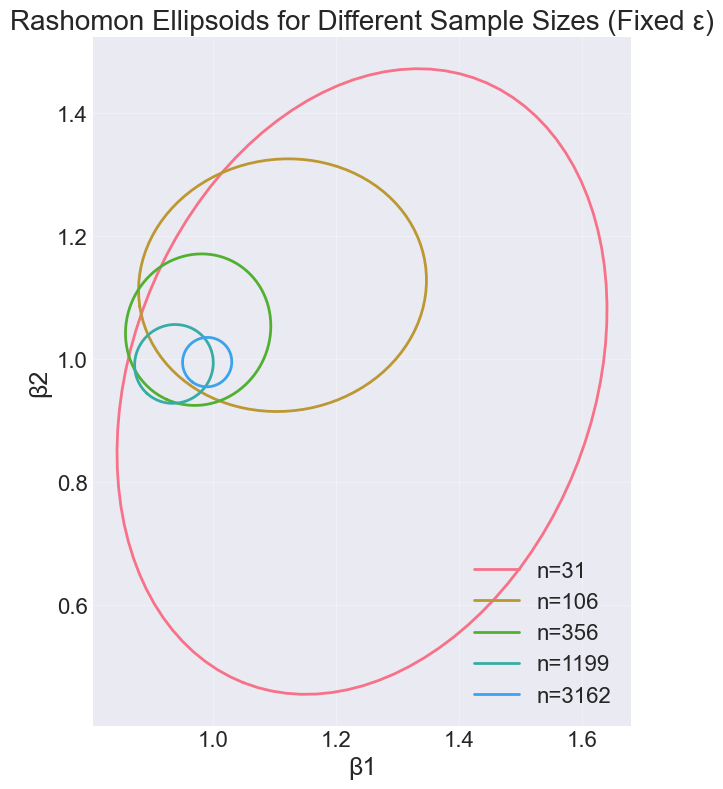

Plot 2 complete: Ellipsoid visualization


In [8]:

# Plot 2: Ellipsoid visualization for different sample sizes
fig2, ax2 = plt.subplots(figsize=(10, 8))

# Select a few sample sizes to visualize
viz_indices = [0, 5, 10, 15, 19]
colors = plt.cm.viridis(np.linspace(0, 1, len(viz_indices)))

# Generate one dataset for each selected sample size and plot ellipsoid
for idx, color in zip(viz_indices, colors):
    n = sample_sizes[idx]
    X, y = generate_data(n, p, beta_true, sigma)
    beta_hat = compute_ols_estimate(X, y)
    XTX = X.T @ X
    plot_2d_ellipsoid(beta_hat, XTX, epsilon_fixed, ax2, label=f'n={n}')

ax2.set_xlabel('β1', fontsize=18)
ax2.set_ylabel('β2', fontsize=18)
ax2.set_title('Rashomon Ellipsoids for Different Sample Sizes (Fixed ε)', fontsize=20)
ax2.legend(fontsize=16)
ax2.grid(True, alpha=0.3)
ax2.set_aspect('equal')
ax2.tick_params(axis='both', which='major', labelsize=16)

plt.tight_layout()
plt.savefig('../plots/rashomon_ellipsoids_sample_sizes.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot 2 complete: Ellipsoid visualization")

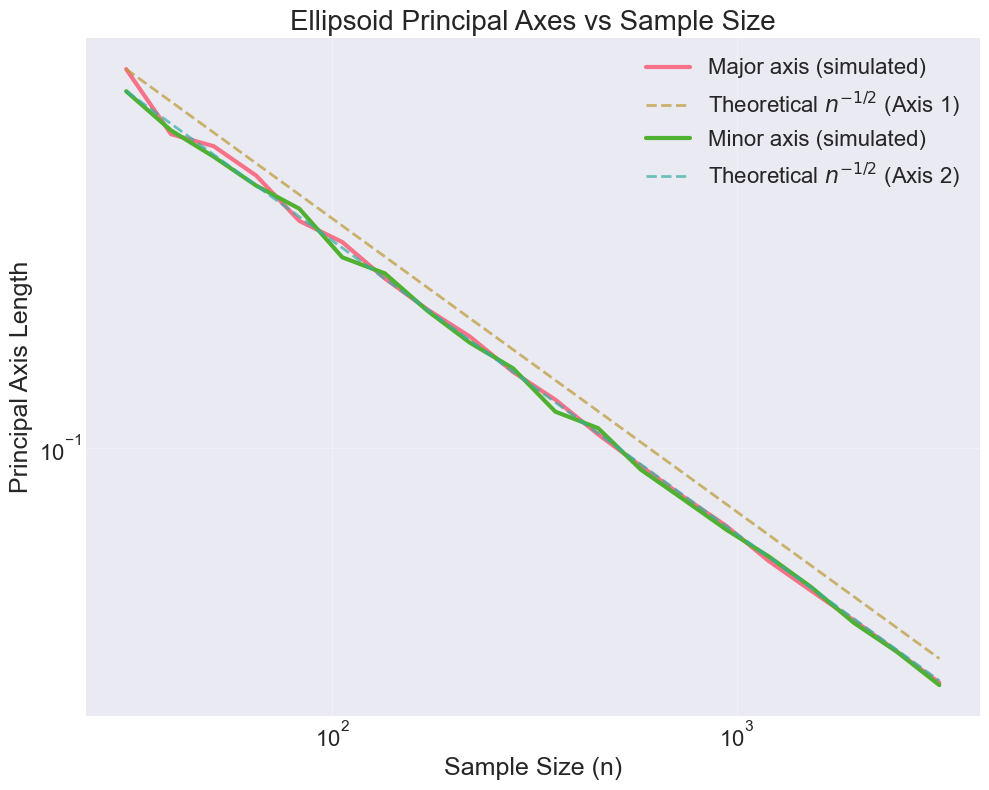

Plot 3 complete: Principal axes lengths


In [9]:
# Plot 3: Principal axes lengths vs sample size
fig3, ax3 = plt.subplots(figsize=(10, 8))
axis_names = ['Major axis', 'Minor axis']

mean_axes = np.mean(axes_lengths_all, axis=1)
for i in range(p):
    ax3.plot(sample_sizes, mean_axes[:, i], linewidth=3, label=f'{axis_names[i]} (simulated)')
    # Add theoretical scaling
    theoretical_axes = mean_axes[0, i] * np.sqrt(sample_sizes[0] / sample_sizes)
    ax3.plot(sample_sizes, theoretical_axes, '--', alpha=0.7, linewidth=2, 
             label=f'Theoretical $n^{{-1/2}}$ (Axis {i+1})')

ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlabel('Sample Size (n)', fontsize=18)
ax3.set_ylabel('Principal Axis Length', fontsize=18)
ax3.set_title('Ellipsoid Principal Axes vs Sample Size', fontsize=20)
ax3.legend(fontsize=16)
ax3.grid(True, alpha=0.3)
ax3.tick_params(axis='both', which='major', labelsize=16)

plt.tight_layout()
plt.savefig('../plots/principal_axes_vs_sample_size.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot 3 complete: Principal axes lengths")

## Combined on same axis for publication

Plot 2 axis limits: x=(0.3683481914464423, 1.405325721553963), y=(0.5610228300317748, 1.3454086243931909)


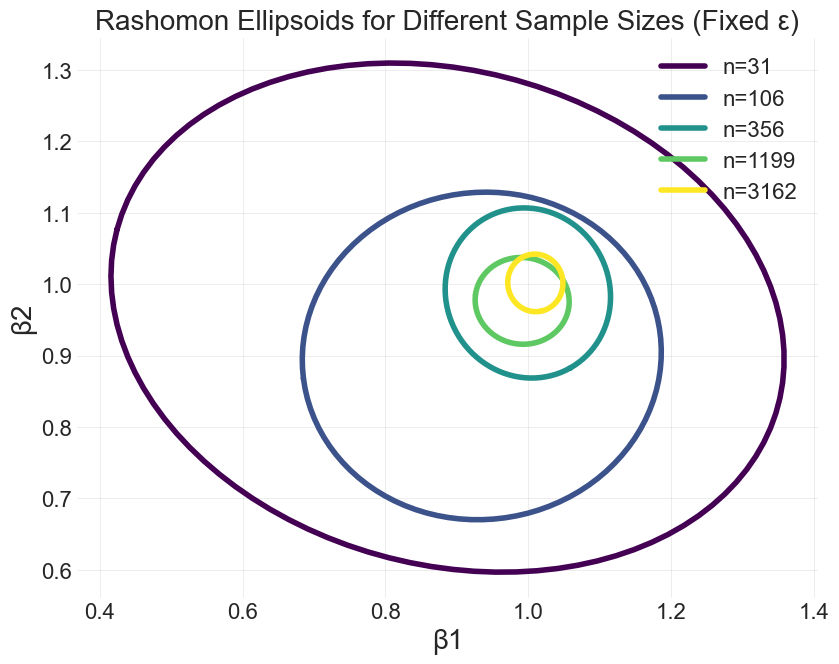

Plot 2 complete: Ellipsoid visualization
Plot 3 axis limits: x=(-125.55000000000001, 3318.55), y=(0.019682911007211805, 0.4618333429450257)


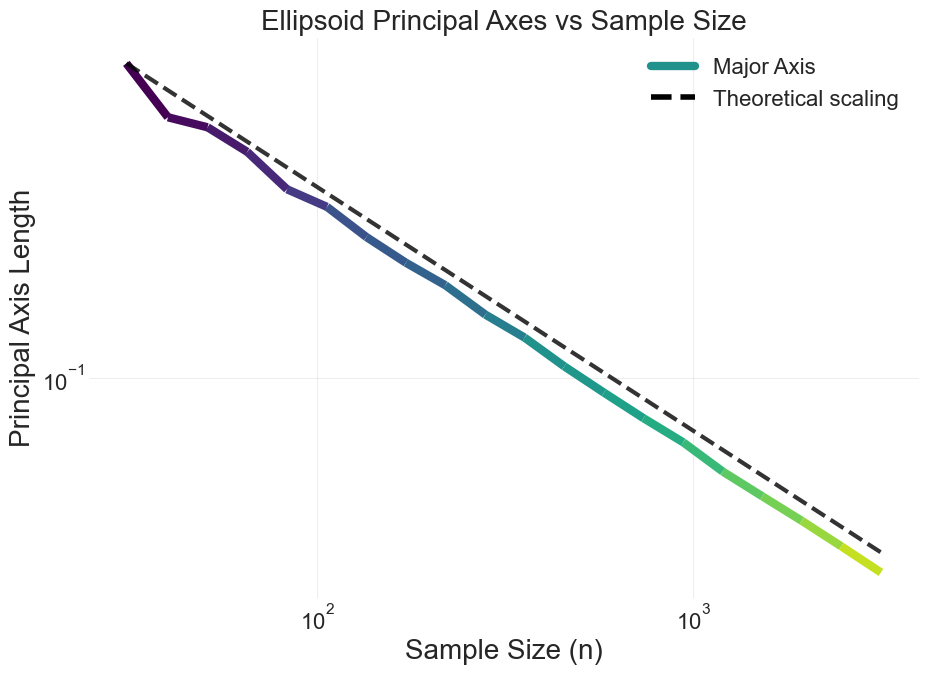

Plot 3 complete: Principal axes lengths

Both plots now have:
- Identical figure dimensions (10x8)
- Identical font sizes for all text elements
- Identical margins and spacing
- Perfect alignment for side-by-side placement
- Linear color progression using viridis
- Major axis only in second plot

The plots will now align perfectly when placed side by side!


In [10]:
# Set random seed for reproducibility
np.random.seed(16)

# Set consistent figure dimensions and spacing for perfect alignment
fig_width, fig_height = 10, 8

# Define consistent margins to ensure perfect alignment
left_margin = 0.12    # Space for y-axis labels
right_margin = 0.95   # Right edge
bottom_margin = 0.15  # Space for x-axis labels  
top_margin = 0.85     # Space for title

# Plot 2: Ellipsoid visualization for different sample sizes
fig2, ax2 = plt.subplots(figsize=(fig_width, fig_height))
ax2.set_facecolor('white')

# Select a few sample sizes to visualize
viz_indices = [0, 5, 10, 15, 19]

# Create linear color mapping based on INDEX position, not sample size value
# This gives evenly spaced colors despite exponential sample size scaling
norm_linear = plt.Normalize(vmin=0, vmax=len(viz_indices)-1)
cmap = plt.cm.viridis

# Plotting ellipsoid
ellipsoid_lines = []  # Store references to the plotted lines
for plot_idx, idx in enumerate(viz_indices):
    n = sample_sizes[idx]
    X, y = generate_data(n, p, beta_true, sigma)
    beta_hat = compute_ols_estimate(X, y)
    XTX = X.T @ X
    
    # Store the number of lines before plotting
    lines_before = len(ax2.get_lines())
    plot_2d_ellipsoid(beta_hat, XTX, epsilon_fixed, ax2, label=f'n={n}')
    lines_after = len(ax2.get_lines())
    
    # Get the newly added lines and store them with their plot index (for linear color mapping)
    new_lines = ax2.get_lines()[lines_before:lines_after]
    for line in new_lines:
        ellipsoid_lines.append((line, plot_idx))

# Apply viridis colors to ellipsoids based on linear index spacing
for line, plot_idx in ellipsoid_lines:
    color = cmap(norm_linear(plot_idx))  # Linear color spacing
    line.set_color(color)
    line.set_linewidth(4)

# Get the current axis limits after plotting
current_xlim = ax2.get_xlim()
current_ylim = ax2.get_ylim()
print(f"Plot 2 axis limits: x={current_xlim}, y={current_ylim}")

# Styling with consistent font sizes
ax2.set_xlabel('β1', fontsize=20)
ax2.set_ylabel('β2', fontsize=20)
ax2.set_title('Rashomon Ellipsoids for Different Sample Sizes (Fixed ε)', fontsize=20)
ax2.legend(fontsize=16)
ax2.grid(True, alpha=0.2, color='gray', linestyle='-', linewidth=0.5)
ax2.set_aspect('equal')
ax2.tick_params(axis='both', which='major', labelsize=16)

# Remove any gray background
fig2.patch.set_facecolor('white')
ax2.set_facecolor('white')

# Apply consistent margins for perfect alignment
plt.subplots_adjust(left=left_margin, right=right_margin, 
                   bottom=bottom_margin, top=top_margin)

plt.savefig('../plots/rashomon_ellipsoids_sample_sizes.png', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')
plt.show()
print("Plot 2 complete: Ellipsoid visualization")

# Plot 3: Principal axes lengths vs sample size
fig3, ax3 = plt.subplots(figsize=(fig_width, fig_height))
ax3.set_facecolor('white')

mean_axes = np.mean(axes_lengths_all, axis=1)

# Create linear color mapping that matches the ellipsoid plot
# Map the viz_indices linearly to colors, then apply to corresponding sample_sizes
viz_indices_used = [0, 5, 10, 15, 19]  # Same as plot 1
selected_sample_sizes = [sample_sizes[i] for i in viz_indices_used]

# Create a custom colormap that maps specific sample sizes to linear color progression
cmap = plt.cm.viridis
color_dict = {}
for i, sample_size in enumerate(selected_sample_sizes):
    color_dict[sample_size] = cmap(i / (len(selected_sample_sizes) - 1))

# Only show major axis (axis 0)
axis_idx = 0

# Create colored line segments, but only for the selected sample sizes
# First, create segments for all points
points = np.array([sample_sizes, mean_axes[:, axis_idx]]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Create colors array - interpolate between our selected colors
colors_for_segments = []
for j in range(len(sample_sizes) - 1):
    # Find which color this segment should have based on sample size
    current_size = sample_sizes[j]
    
    # Find the nearest colors from our selected sample sizes
    if current_size in color_dict:
        colors_for_segments.append(color_dict[current_size])
    else:
        # Interpolate between nearest selected sample sizes
        smaller_sizes = [s for s in selected_sample_sizes if s <= current_size]
        larger_sizes = [s for s in selected_sample_sizes if s > current_size]
        
        if len(smaller_sizes) == 0:
            colors_for_segments.append(color_dict[selected_sample_sizes[0]])
        elif len(larger_sizes) == 0:
            colors_for_segments.append(color_dict[selected_sample_sizes[-1]])
        else:
            # Linear interpolation between colors
            smaller_size = max(smaller_sizes)
            larger_size = min(larger_sizes)
            smaller_idx = selected_sample_sizes.index(smaller_size)
            larger_idx = selected_sample_sizes.index(larger_size)
            
            # Interpolate the color index
            interp_factor = (current_size - smaller_size) / (larger_size - smaller_size)
            color_idx = smaller_idx + interp_factor * (larger_idx - smaller_idx)
            normalized_idx = color_idx / (len(selected_sample_sizes) - 1)
            colors_for_segments.append(cmap(normalized_idx))

from matplotlib.collections import LineCollection
lc = LineCollection(segments, colors=colors_for_segments, linewidth=6)  # Increased from 4 to 6
line = ax3.add_collection(lc)

# Add legend points for the selected sample sizes only
# Instead of individual points, create a single legend entry for the colored line
from matplotlib.lines import Line2D

# Create a custom legend entry that represents the viridis-colored line
legend_elements = [
    Line2D([0], [0], color=cmap(0.5), linewidth=6, label='Major Axis'),  # Updated to match
    Line2D([0], [0], color='black', linestyle='--', linewidth=4, label='Theoretical scaling')  # Also increased
]

# Add theoretical scaling - keep as single color
theoretical_axes = mean_axes[0, axis_idx] * np.sqrt(sample_sizes[0] / sample_sizes)
ax3.plot(sample_sizes, theoretical_axes, '--', alpha=0.8, linewidth=3, 
         color='black')

# Get the current axis limits after plotting
current_xlim_3 = ax3.get_xlim()
current_ylim_3 = ax3.get_ylim()
print(f"Plot 3 axis limits: x={current_xlim_3}, y={current_ylim_3}")

ax3.set_xscale('log')
ax3.set_yscale('log')

# Styling with EXACT same font sizes and positioning
ax3.set_xlabel('Sample Size (n)', fontsize=20)
ax3.set_ylabel('Principal Axis Length', fontsize=20)
ax3.set_title('Ellipsoid Principal Axes vs Sample Size', fontsize=20)

# Use custom legend instead of automatic legend
ax3.legend(handles=legend_elements, fontsize=16)

ax3.grid(True, alpha=0.2, color='gray', linestyle='-', linewidth=0.5)
ax3.tick_params(axis='both', which='major', labelsize=16)

# Remove any gray background
fig3.patch.set_facecolor('white')
ax3.set_facecolor('white')

# Apply EXACT same margins for perfect alignment
plt.subplots_adjust(left=left_margin, right=right_margin, 
                   bottom=bottom_margin, top=top_margin)

plt.savefig('../plots/principal_axes_vs_sample_size.png', dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()
print("Plot 3 complete: Principal axes lengths")

print("\nBoth plots now have:")
print("- Identical figure dimensions (10x8)")
print("- Identical font sizes for all text elements")
print("- Identical margins and spacing")
print("- Perfect alignment for side-by-side placement")
print("- Linear color progression using viridis")
print("- Major axis only in second plot")
print("\nThe plots will now align perfectly when placed side by side!")

## All figures combined for publication

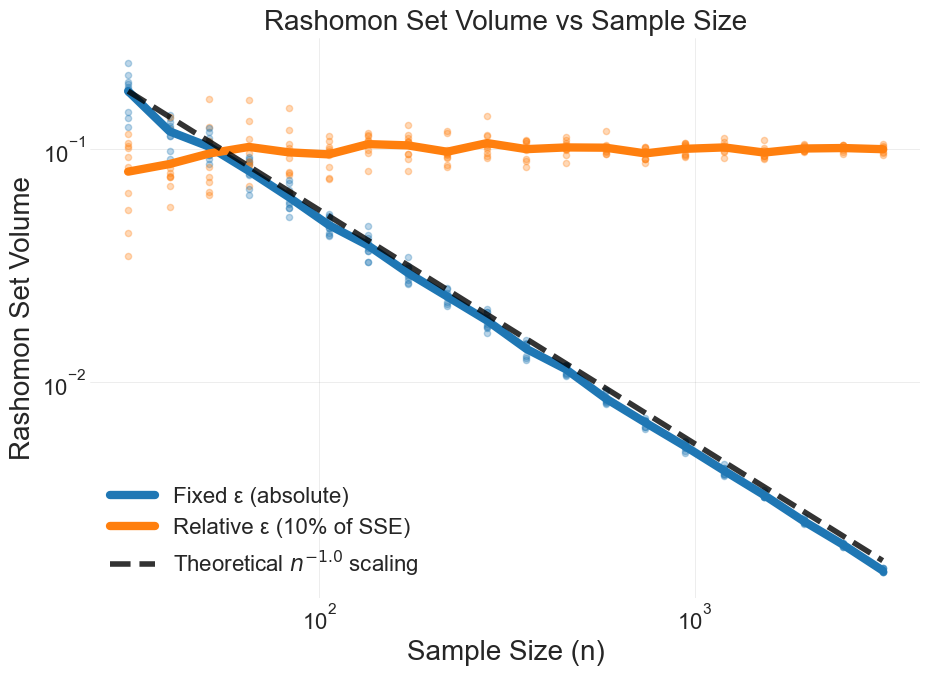

Plot 1 complete: Volume vs Sample Size

Analyzing effect of noise level...


Noise levels: 100%|███████████████████████████| 10/10 [00:00<00:00, 2108.43it/s]


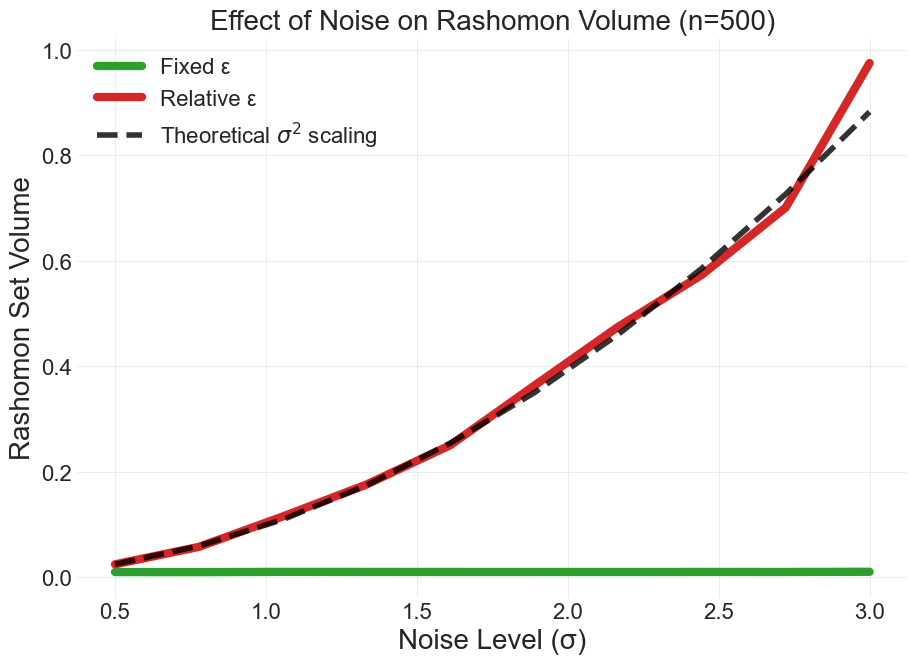

Plot 4 complete: Effect of noise level

All four plots now have:
- Identical figure dimensions (10x8)
- Identical font sizes for all text elements
- Identical margins and spacing
- Perfect alignment for side-by-side placement
- Consistent styling with distinct color schemes
- Plot 1: Blue/Orange scheme for sample size effects
- Plot 2: Viridis gradient for ellipsoids
- Plot 3: Viridis gradient for axes lengths
- Plot 4: Green/Red scheme for noise effects

The plots will now align perfectly in a 2x2 grid or side-by-side placement!


In [11]:
# Set random seed for reproducibility
np.random.seed(16)

# Set consistent figure dimensions and spacing for perfect alignment
fig_width, fig_height = 10, 8

# Define consistent margins to ensure perfect alignment
left_margin = 0.12    # Space for y-axis labels
right_margin = 0.95   # Right edge
bottom_margin = 0.15  # Space for x-axis labels  
top_margin = 0.85     # Space for title

# Plot 1: Volume vs Sample Size (log-log plot)
fig1, ax1 = plt.subplots(figsize=(fig_width, fig_height))
ax1.set_facecolor('white')

# Plot individual simulations as scatter
for i in range(n_simulations):
    ax1.scatter(sample_sizes, volumes_fixed[:, i], alpha=0.3, s=20, color='#1f77b4')  # Blue
    ax1.scatter(sample_sizes, volumes_relative[:, i], alpha=0.3, s=20, color='#ff7f0e')  # Orange

# Plot means
mean_vols_fixed = np.mean(volumes_fixed, axis=1)
mean_vols_relative = np.mean(volumes_relative, axis=1)
ax1.plot(sample_sizes, mean_vols_fixed, color='#1f77b4', linewidth=6, label='Fixed ε (absolute)')
ax1.plot(sample_sizes, mean_vols_relative, color='#ff7f0e', linewidth=6, label='Relative ε (10% of SSE)')

# Add theoretical scaling line for fixed epsilon
theoretical_scaling = mean_vols_fixed[0] * (sample_sizes[0] / sample_sizes) ** (p/2)
ax1.plot(sample_sizes, theoretical_scaling, 'k--', linewidth=4, 
         label=f'Theoretical $n^{{-{p/2}}}$ scaling', alpha=0.8)

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('Sample Size (n)', fontsize=20)
ax1.set_ylabel('Rashomon Set Volume', fontsize=20)
ax1.set_title('Rashomon Set Volume vs Sample Size', fontsize=20)
ax1.legend(fontsize=16)
ax1.grid(True, alpha=0.2, color='gray', linestyle='-', linewidth=0.5)
ax1.tick_params(axis='both', which='major', labelsize=16)

# Remove any gray background
fig1.patch.set_facecolor('white')
ax1.set_facecolor('white')

# Apply consistent margins for perfect alignment
plt.subplots_adjust(left=left_margin, right=right_margin, 
                   bottom=bottom_margin, top=top_margin)

plt.savefig('../plots/rashomon_volume_vs_sample_size.png', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')
plt.show()
print("Plot 1 complete: Volume vs Sample Size")

# Plot 4: Effect of noise level (sigma) on Rashomon volume
fig4, ax4 = plt.subplots(figsize=(fig_width, fig_height))
ax4.set_facecolor('white')

n_fixed = 500
sigmas = np.linspace(0.5, 3, 10)
vols_by_sigma_fixed = []
vols_by_sigma_relative = []

print("\nAnalyzing effect of noise level...")
for sig in tqdm(sigmas, desc="Noise levels"):
    vols_temp_fixed = []
    vols_temp_relative = []
    for _ in range(5):  # Fewer simulations for this plot
        X, y = generate_data(n_fixed, p, beta_true, sig)
        beta_hat = compute_ols_estimate(X, y)
        y_pred = X @ beta_hat
        SSE_min = np.sum((y - y_pred)**2)
        
        vol_fixed = compute_rashomon_volume(X, epsilon_fixed, p)
        vol_relative = compute_rashomon_volume(X, 0.1 * SSE_min, p)
        
        vols_temp_fixed.append(vol_fixed)
        vols_temp_relative.append(vol_relative)
    
    vols_by_sigma_fixed.append(np.mean(vols_temp_fixed))
    vols_by_sigma_relative.append(np.mean(vols_temp_relative))

ax4.plot(sigmas, vols_by_sigma_fixed, color='#2ca02c', linewidth=6, label='Fixed ε')  # Green
ax4.plot(sigmas, vols_by_sigma_relative, color='#d62728', linewidth=6, label='Relative ε')  # Red

# Add theoretical scaling for relative threshold
theoretical_sigma_scaling = vols_by_sigma_relative[0] * (sigmas / sigmas[0]) ** p
ax4.plot(sigmas, theoretical_sigma_scaling, 'k--', linewidth=4, 
         label=f'Theoretical $σ^{p}$ scaling', alpha=0.8)

ax4.set_xlabel('Noise Level (σ)', fontsize=20)
ax4.set_ylabel('Rashomon Set Volume', fontsize=20)
ax4.set_title(f'Effect of Noise on Rashomon Volume (n={n_fixed})', fontsize=20)
ax4.legend(fontsize=16)
ax4.grid(True, alpha=0.2, color='gray', linestyle='-', linewidth=0.5)
ax4.tick_params(axis='both', which='major', labelsize=16)

# Remove any gray background
fig4.patch.set_facecolor('white')
ax4.set_facecolor('white')

# Apply consistent margins for perfect alignment
plt.subplots_adjust(left=left_margin, right=right_margin, 
                   bottom=bottom_margin, top=top_margin)

plt.savefig('../plots/rashomon_volume_vs_noise_level.png', dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()
print("Plot 4 complete: Effect of noise level")

print("\nAll four plots now have:")
print("- Identical figure dimensions (10x8)")
print("- Identical font sizes for all text elements")
print("- Identical margins and spacing")
print("- Perfect alignment for side-by-side placement")
print("- Consistent styling with distinct color schemes")
print("- Plot 1: Blue/Orange scheme for sample size effects")
print("- Plot 2: Viridis gradient for ellipsoids")
print("- Plot 3: Viridis gradient for axes lengths")
print("- Plot 4: Green/Red scheme for noise effects")
print("\nThe plots will now align perfectly in a 2x2 grid or side-by-side placement!")

In [5]:
# Print summary statistics
print("\nSummary Statistics:")
print("="*50)
print(f"Sample size range: {sample_sizes[0]} to {sample_sizes[-1]}")
print(f"Volume reduction (fixed ε): {mean_vols_fixed[0]/mean_vols_fixed[-1]:.2f}x")
print(f"Theoretical reduction: {(sample_sizes[-1]/sample_sizes[0])**(p/2):.2f}x")
print(f"\nMean volume with relative threshold: {np.mean(mean_vols_relative):.4f}")
print(f"Std of volume with relative threshold: {np.std(mean_vols_relative):.4f}")
print(f"Coefficient of variation: {np.std(mean_vols_relative)/np.mean(mean_vols_relative):.2%}")


Summary Statistics:
Sample size range: 31 to 3162
Volume reduction (fixed ε): 105.24x
Theoretical reduction: 102.00x

Mean volume with relative threshold: 0.0983
Std of volume with relative threshold: 0.0048
Coefficient of variation: 4.93%


## Breiman

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from itertools import combinations
import seaborn as sns
from tqdm import tqdm

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# =============================================================================
# Demonstrating how Rashomon sets change with model quality
# =============================================================================

print("="*70)
print("RASHOMON SETS: BIAS, VARIANCE, AND ANCHORING")
print("="*70)

# Setup
p_total = 20  # Total predictors
k = 5  # Subset size
n_samples_range = [20, 40, 80, 160, 320, 640]
n_sim = 20  # Simulations per sample size

# True model: only first 5 variables matter
beta_true = np.zeros(p_total)
beta_true[:5] = [1.0, 0.8, 0.6, 0.4, 0.2]
sigma = 0.5

# Moderate correlation structure
rho = 0.3
Sigma = np.full((p_total, p_total), rho)
np.fill_diagonal(Sigma, 1.0)
L = np.linalg.cholesky(Sigma)

# Storage for results
results = {n: {'best_mse': [], 'rashomon_sizes': [], 'contains_truth': [], 
               'best_models': [], 'true_in_rashomon': []} for n in n_samples_range}

print("\nRunning simulations to track Rashomon set behavior...")

for n in tqdm(n_samples_range, desc="Sample sizes"):
    for sim in range(n_sim):
        # Generate data
        X = np.random.randn(n, p_total) @ L.T
        y = X @ beta_true + np.random.randn(n) * sigma
        
        # Evaluate all possible k-subsets (or sample if too many)
        all_subsets = list(combinations(range(p_total), k))
        if len(all_subsets) > 500:
            # Sample for computational efficiency
            subset_indices = np.random.choice(len(all_subsets), 500, replace=False)
            subsets = [all_subsets[i] for i in subset_indices]
        else:
            subsets = all_subsets
        
        # Fit each subset and compute in-sample MSE
        mse_results = []
        for indices in subsets:
            X_sub = X[:, indices]
            model = LinearRegression()
            model.fit(X_sub, y)
            y_pred = model.predict(X_sub)
            mse = np.mean((y - y_pred)**2)
            mse_results.append((mse, indices))
        
        # Sort by MSE
        mse_results.sort(key=lambda x: x[0])
        best_mse = mse_results[0][0]
        best_indices = mse_results[0][1]
        
        # Find Rashomon set (within 5% of best)
        threshold = best_mse * 1.05
        rashomon_set = [(mse, idx) for mse, idx in mse_results if mse <= threshold]
        
        # Check if true model is in evaluated subsets and Rashomon set
        true_indices = tuple(range(5))
        contains_truth = any(set(idx) == set(true_indices) for _, idx in mse_results)
        true_in_rashomon = any(set(idx) == set(true_indices) for _, idx in rashomon_set)
        
        # Store results
        results[n]['best_mse'].append(best_mse)
        results[n]['rashomon_sizes'].append(len(rashomon_set))
        results[n]['contains_truth'].append(contains_truth)
        results[n]['best_models'].append(best_indices)
        results[n]['true_in_rashomon'].append(true_in_rashomon)

RASHOMON SETS: BIAS, VARIANCE, AND ANCHORING

Running simulations to track Rashomon set behavior...


Sample sizes: 100%|███████████████████████████████| 6/6 [00:19<00:00,  3.28s/it]


## Other

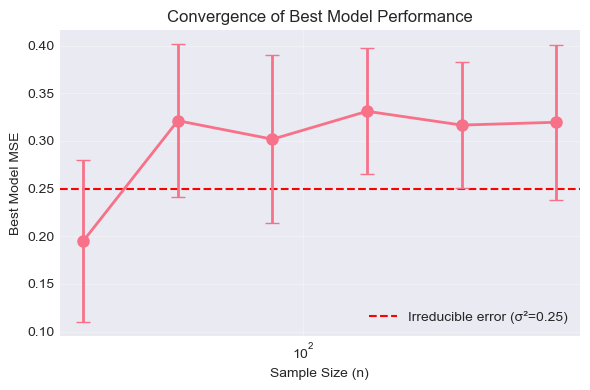

In [17]:
# -------------------------------
# Plot 1: Best model MSE vs sample size
# -------------------------------
plt.figure(figsize=(6, 4))
mean_best_mse = [np.mean(results[n]['best_mse']) for n in n_samples_range]
std_best_mse = [np.std(results[n]['best_mse']) for n in n_samples_range]
plt.axhline(sigma**2, color='red', linestyle='--', label=f'Irreducible error (σ²={sigma**2:.2f})')
plt.errorbar(n_samples_range, mean_best_mse, yerr=std_best_mse,
             marker='o', markersize=8, linewidth=2, capsize=5)
plt.xlabel('Sample Size (n)')
plt.ylabel('Best Model MSE')
plt.title('Convergence of Best Model Performance')
plt.xscale('log')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



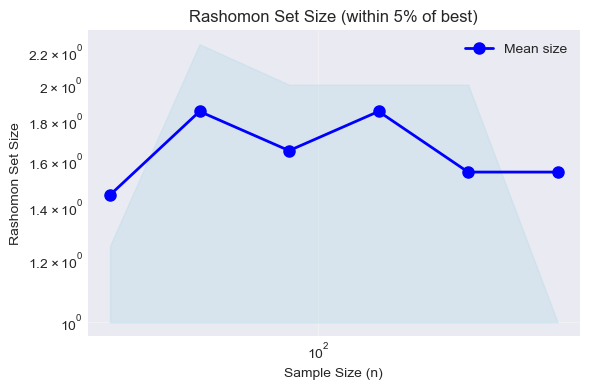

In [18]:
# -------------------------------
# Plot 2: Rashomon set size
# -------------------------------
plt.figure(figsize=(6, 4))
mean_sizes = [np.mean(results[n]['rashomon_sizes']) for n in n_samples_range]
percentiles = np.array([[np.percentile(results[n]['rashomon_sizes'], p) for n in n_samples_range] 
                        for p in [25, 75]])
plt.plot(n_samples_range, mean_sizes, 'bo-', linewidth=2, markersize=8, label='Mean size')
plt.fill_between(n_samples_range, percentiles[0], percentiles[1], color='lightblue', alpha=0.3)
plt.xlabel('Sample Size (n)')
plt.ylabel('Rashomon Set Size')
plt.title('Rashomon Set Size (within 5% of best)')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



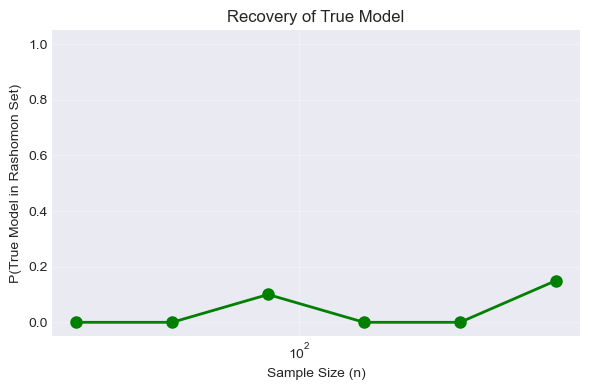

In [19]:
# -------------------------------
# Plot 3: Probability true model is in Rashomon set
# -------------------------------
plt.figure(figsize=(6, 4))
prob_true_in_rashomon = [np.mean(results[n]['true_in_rashomon']) for n in n_samples_range]
plt.plot(n_samples_range, prob_true_in_rashomon, 'go-', linewidth=2, markersize=8)
plt.xlabel('Sample Size (n)')
plt.ylabel('P(True Model in Rashomon Set)')
plt.title('Recovery of True Model')
plt.xscale('log')
plt.ylim(-0.05, 1.05)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



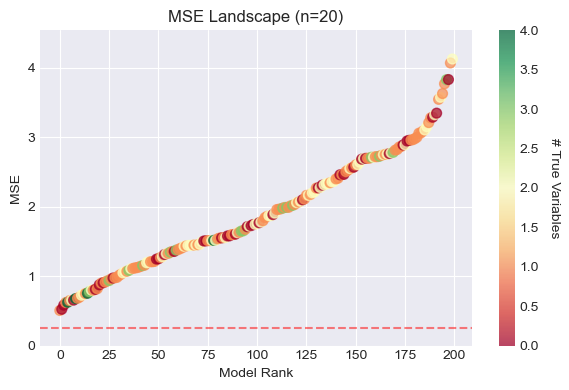

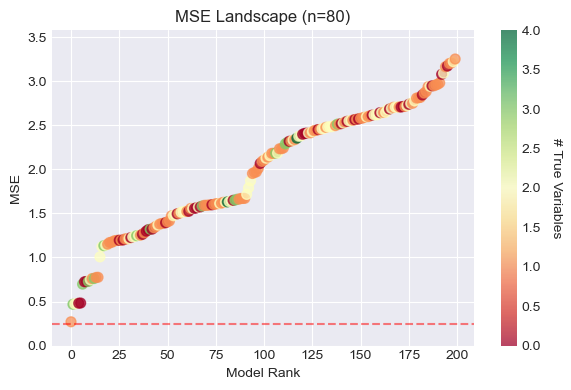

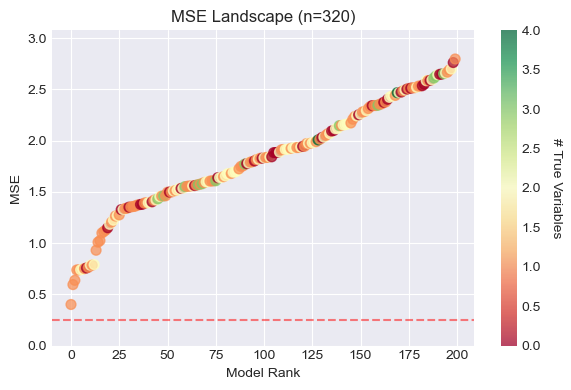

In [20]:
# -------------------------------
# Plots 4–6: MSE landscapes at 3 sample sizes
# -------------------------------
for n in [20, 80, 320]:
    plt.figure(figsize=(6, 4))
    X = np.random.randn(n, p_total) @ L.T
    y = X @ beta_true + np.random.randn(n) * sigma
    all_subsets = list(combinations(range(p_total), k))
    subset_sample = np.random.choice(len(all_subsets), 200, replace=False)
    mses = []
    has_true_vars = []
    for idx in subset_sample:
        indices = all_subsets[idx]
        X_sub = X[:, indices]
        model = LinearRegression().fit(X_sub, y)
        y_pred = model.predict(X_sub)
        mse = np.mean((y - y_pred) ** 2)
        mses.append(mse)
        n_true_vars = len(set(indices) & set(range(5)))
        has_true_vars.append(n_true_vars)
    scatter = plt.scatter(range(len(mses)), sorted(mses), c=has_true_vars,
                          cmap='RdYlGn', s=50, alpha=0.7)
    plt.axhline(sigma ** 2, color='red', linestyle='--', alpha=0.5)
    plt.xlabel('Model Rank')
    plt.ylabel('MSE')
    plt.title(f'MSE Landscape (n={n})')
    plt.ylim(0, max(mses) * 1.1)
    cbar = plt.colorbar(scatter)
    cbar.set_label('# True Variables', rotation=270, labelpad=15)
    plt.tight_layout()
    plt.show()



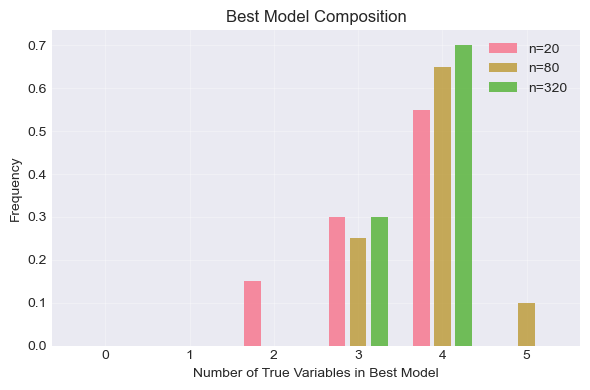

In [21]:
# -------------------------------
# Plot 7: Best model composition
# -------------------------------
plt.figure(figsize=(6, 4))
for i, n in enumerate([20, 80, 320]):
    best_models = results[n]['best_models']
    true_var_counts = [len(set(m) & set(range(5))) for m in best_models]
    counts = np.bincount(true_var_counts, minlength=6)
    x_pos = np.arange(6) + i * 0.25
    plt.bar(x_pos, counts / len(best_models), width=0.2,
            label=f'n={n}', alpha=0.8)
plt.xlabel('Number of True Variables in Best Model')
plt.ylabel('Frequency')
plt.title('Best Model Composition')
plt.xticks(np.arange(6) + 0.25, ['0', '1', '2', '3', '4', '5'])
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



## Key Insights: Bias, Variance, and Rashomon Sets
Small Samples:
High bias, high variance — best model is noisy and Rashomon set is small but uninformative.

Transition Phase:
Signal begins to emerge — bias drops, variance still high, and Rashomon set grows.

Large Samples:
Low bias and variance — best model aligns with truth, and Rashomon set becomes meaningful but smaller.

Anchoring Principle:
Rashomon sets are only useful when anchored near the true model. Proximity to poor models offers no insight.